# Miami Hotels - Search Engine

## Description

The purpose of the homework is to implement a similar hotel search engine using the [Miami Hotels][miami_hotels_url] datase.

The general breakdown of the homework is the following:

1. Data Processing
2. API Development
3. Summary generation for a single Hotel
4. Summarize findings in Notion

Each section will be broken down in the following sections

### 1. Data Processing and General Search Engine

This portion of the project will deal with the pre-processing of the data, in order the dataset that will be used for creating the Hotel Search Engine.

This dataset will be comprised of the `Miami Hotels` dataset (from Github). Once the preprocessing tasks are performed on the dataset, the group will create the Search Engine for all the hotels in the dataset.

We'll implement the [MPNet][MPnet_HuggingFace] model ([paper][MPnet_arxiv_paper]) using the *Miami Hotels* dataset to create the Search Engine.

Finally, we'll provide a function to run a search on *all* hotels using the text embeddings from above.

### 2. API Development

The idea of this portion of the project is to create an API that uses the Search Engine from above, in order to be able to search the database in real-time.

We'll use [gradio][gradio_url] to create the service and the API endpoint that one can use to interact with the model.

### 3. Summary generation for a Single Hotel

We'll implement a method (e.g. [Aspect-based Sentiment Analysis][aspect_based_medium_url]) to create a model that *summarizes* the information about a single hotel.

### 4. Summary of the findings

This port of the analysis will summarize all of the findings and model development efforts from this assignment.

The Notion document can be found here: [Notion Doc][notion_doc_url]

---

<!-- Links -->

[miami_hotels_url]: https://raw.githubusercontent.com/hamzafarooq/maven-mlsystem-design-cohort-1/main/data/miami_hotels.csv

[MPnet_HuggingFace]: https://huggingface.co/docs/transformers/model_doc/mpnet

[MPnet_arxiv_paper]: https://arxiv.org/abs/2004.09297

[gradio_url]: https://gradio.app/

[aspect_based_medium_url]: https://medium.com/nlplanet/quick-intro-to-aspect-based-sentiment-analysis-c8888a09eda7

[notion_doc_url]: https://petalite-toy-fea.notion.site/Week-4-Group-5-Miami-Hotels-Analysis-c30a1d99635c492d8b8b7e5635a0f9cc

# Importing modules

In [ ]:
# !pip list


In [5]:
# Importing 'locale'
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# !pip install -q -U spacy
# !pip install -q -U faiss-cpu
# !pip install -q -U sentence-transformers
# !pip install -q -U rank_bm25
# !pip install -q -U openai
# !pip install -q -U torch
# !pip install -q -U tiktoken
# !pip install -q -U requests
# !pip install -q -U sentence-transformers
# !pip install -q -U packaging
# !pip install -q -U tqdm
# !pip install -q -U gradio

In [ ]:
# # !pip install -q -U sentence-transformers
# # !pip install -q -U openai
# !pip install matplotlib


In [1]:
import pandas as pd
import logging
import numpy as np
from typing import List, Tuple, Optional, Dict
from pathlib import Path
import re
from spacy.lang.en.stop_words import STOP_WORDS
from sentence_transformers import SentenceTransformer
import faiss
import os
from getpass import getpass
# from openai.embeddings_utils import get_embedding, cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import torch
from datetime import datetime
import json
import gradio as gr
import requests
import tiktoken
from sentence_transformers import SentenceTransformer
import faiss
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import packaging
import itertools
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image as PilImage
import matplotlib.pyplot as plt
import math
import io

c:\Users\Tiger\anaconda3\envs\Py310Stanford2\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Defining the logger of the notebook
logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s]: %(message)s",
)
logger.setLevel(logging.INFO)

Next, we can add the OpenAI API key from the following website: [https://platform.openai.com/account/api-keys][openai_api_key]

> Once you have created it and copied it to your clipboard, paste in the text box that will appear after you execute the following cell:

<!-- Links -->

[openai_api_key]: https://platform.openai.com/account/api-keys

In [ ]:
os.environ["OPENAI_API_KEY"] = getpass("")

# Data Processing and data cleaning

As part of the data preprocessing aspect of the data, we first have to download the data and take closer look at what the dataset looks like.

We've created the following class definition to interact with the dataset and
download the corresponding dataset. This class definition is also able to handle the various aspects of the data processing and data cleaning on the raw data.






## Data Prep - Class definition

The following is the class definition and functions that will handle the aspects of data processing and data cleaning of the raw dataset.

The dataset that will used for this project is the [Miami Hotels][miami_hotels_url][link text](https://). This dataset contains reviews of about 65 different hotels, and we'll explore this dataset in later sections.

<!-- Links -->

[miami_hotels_url]: https://raw.githubusercontent.com/hamzafarooq/maven-mlsystem-design-cohort-1/main/data/miami_hotels.csv

In [6]:
# -- Defining functions that can be used for cleaning up and preparing text
class NLPPrep(object):
    """
    Class object for handling the data processing of text.
    """

    def __init__(self):
        # Defining the corresponding stop words
        self.stop_words = list(STOP_WORDS)

    def _lowercase_text(self, input_string: str) -> str:
        """
        Method for making the input text lowercase.

        Parameters
        ------------
        input_string : str
            Text variable to lowercase.

        Returns
        ----------
        output_string : str
            Lower-cased version of ``input_string``.
        """

        return input_string.lower()

    def _only_keep_alphanumeric(self, input_string: str) -> str:
        """
        Method for only keeping alphanumerical characters in the text.

        Parameters
        ------------
        input_string : str
            Text variable to filter.

        Returns
        ----------
        output_string : str
            Filtered version of ``input_string`` that only contains
            alphanumerical characters.
        """
        regex_pattern = "[^a-zA-z0-9\s]"

        return re.sub(regex_pattern, "", str(input_string))

    def _remove_stopwords(self, input_string: str) -> str:
        """
        Method for removing stop words from the input text.

        Parameters
        ------------
        input_string : str
            Text variable to filter.

        Returns
        ----------
        output_string : str
            Filtered version of ``input_string`` without stop words in the text.
        """
        # Splitting the text into 'tokens'
        tokens = input_string.strip().split()

        return " ".join(
            [word for word in tokens if word not in self.stop_words]
        )

    def process_text(self, input_string: str) -> str:
        """
        Method for passing the input variable through NLP-based techniques
        to process the text.

        Parameters
        ------------
        input_string : str
            Variable corresponding to the text that will be processed.

        Returns
        ------------
        processed_string : str
            Variable corresponding to the *processed* version of the input
            string, after having gone through some NLP-based processing
            techniques.

        Notes
        -----------
        This function will perform the following NLP-based techniques:

        1. Make the text lowercase.
        2. Remove any non-alphanumeric character from the string.
        3. Remove any stop words from the text.
        """
        # Lower case the text
        processed_string = self._lowercase_text(input_string)
        # Removing non-alphanumeric characters
        processed_string = self._only_keep_alphanumeric(processed_string)
        # Removing stop words
        processed_string = self._remove_stopwords(processed_string)

        return processed_string


In [7]:
class DatasetPrep(object):
    """
    Class object for the Data Processing of the input dataset.
    """

    def __init__(self, url: str):
        """
        Class object for the Data Processing of the input dataset.

        Parameters
        ------------
        url : str
          URL of the input dataset
        """
        # Defining data directory
        self.datasets_dir = Path().resolve().joinpath("datasets")
        # Initializing dataset
        self.url = url
        self.raw_dataset = self._download_dataset()
        # Extracting the number of rows and columns, and the column names
        (
            self.n_rows,
            self.n_columns,
            self.column_names,
        ) = self._get_columns_and_shape()

        # Columns to use for filtering the raw dataset.
        self.filtered_columns = self._get_filtered_columns()

        # Initialize NLP-Prep object
        self.nlp_obj = NLPPrep()

    def _download_dataset(
        self,
        save_to_disk: Optional[bool] = True,
    ) -> pd.DataFrame:
        """
        Method for downloading the datset from the specified URL.

        Parameters
        ------------
        save_to_disk : bool, optional
            If ``True``, a copy of the dataset will be saved to disk to the
            local directory. This variable is set to ``True`` by default.

        Returns
        ---------
        raw_dataset : pandas.DataFrame
           DataFrame containing the data from the URL.
        """
        logger.info(f">> Downloading dataset from '{self.url}'")

        # Downloading the dataset
        raw_dataset = pd.read_csv(self.url)

        # Saving to disk, if applicable
        if save_to_disk:
            # Filepath
            filepath = Path(self.datasets_dir).joinpath("raw_dataset.csv")
            filepath.parent.mkdir(parents=True, exist_ok=True)
            raw_dataset.to_csv(filepath, header=True, index=True)

            logger.info(f">> Raw dataset saved to '{str(filepath)}'")

        return pd.read_csv(self.url)

    def _get_columns_and_shape(self) -> Tuple[int, int, List]:
        """
        Method for extracting the columns and information about the
        raw dataset.

        Returns
        ----------
        n_rows : int
            Number of rows in the original dataset.

        n_cols : int
            Number of columns in the original dataset.

        columns : list
            List of the columns in the original dataset.
        """
        # Number of rows and columns
        n_rows, n_columns = self.raw_dataset.shape
        logger.info(
            ">> There are '{}' rows and '{} columns in the dataset".format(
                n_rows, n_columns
            )
        )

        # Column names
        columns_arr = sorted(self.raw_dataset.columns)
        logger.info(
            ">> Columns in the dataset: {}".format("\n\t".join(columns_arr))
        )

        return n_rows, n_columns, columns_arr

    def _get_filtered_columns(self) -> List:
        """
        Method for extracting the set of columns that will be used for the
        filtered version of the raw dataset.

        Returns
        ----------
        filtered_columns : list
            List of the columns to use for the final dataset.
        """

        return [
            "category",
            "address",
            "email",
            "id",
            "name",
            "numberOfReviews",
            "numberOfRooms",
            "priceRange",
            "priceLevel",
            "rankingPosition",
            "rating",
            "title",
            "review",
            "webUrl",
            "hotelClass",
        ]

    def _process_text(self, input_text: str) -> str:
        """
        Method for applying NLP-based techniques on an input text in order to
        prepare it to be used by embedding algorithms.

        Parameters
        ------------
        input_text : str
            Variable corresponding to the input text.

        Returns
        ------------
        processed_text : str
            Processed version of the ``input_text``.

        Notes
        ----------
        This function will perform the following NLP-based techniques:

        1. Make the text lowercase.
        2. Remove any non-alphanumeric character from the string.
        3. Remove any stop words from the text.
        """

        return self.nlp_obj.process_text(input_text)

    def clean_dataset(
        self,
        save_to_disk: Optional[bool] = True,
    ) -> pd.DataFrame:
        """
        Method for cleaning the raw dataset and create its clean version.

        Parameters
        ------------
        save_to_disk : bool, optional
            If ``True``, a copy of the dataset will be saved to disk to the
            local directory. This variable is set to ``True`` by default.

        Returns
        ---------
        dataset_clean : pandas.DataFrame
            Clean version of the input dataset, after having gone through some
            data-cleaning techniques.
        """
        logger.info(">> Starting data cleaning process ...")

        # --- Selecting only the specified columns
        filtered_columns = self._get_filtered_columns()
        logger.info(f">>    Using filtered columns: {filtered_columns}")

        dataset_df = self.raw_dataset[filtered_columns].copy()

        # --- Removing duplicate reviews from the dataset
        if dataset_df.duplicated().sum() > 0:
            n_duplicated = dataset_df.duplicated().sum()
            logger.info(f">> Found '{n_duplicated}' elements in the dataset")
            logger.info(">>    Removing such duplicates ...")
            dataset_df = dataset_df.drop_duplicates().reset_index(drop=True)

        # --- Removing entries that have 'NaN's in the dataset.
        # NOTE: These are the columns that cannot have any NaN's in them
        logger.info(f">>    Removing NaN's from the dataset, if applicable")

        columns_nans = ["id", "review", "priceRange", "rating", "hotelClass"]
        if dataset_df.shape != dataset_df.dropna(subset=columns_nans).shape:
            logger.info(">>    Original shape: {}".format(dataset_df.shape))
            logger.info(
                ">>    After dropping NaNs - shape: {}".format(
                    dataset_df.dropna(subset=columns_nans).shape
                )
            )

            dataset_df = dataset_df.dropna(subset=columns_nans).reset_index(
                drop=True
            )

        # --- Parsing prices
        # NOTE: We'll split the minimum and maximum price range and perform
        # some data processing on the data
        logger.info(">>    Parsing prices from the datataset")

        price_column = "priceRange"
        cost_range_min = "priceMin"
        cost_range_max = "priceMax"

        dataset_df[[cost_range_min, cost_range_max]] = dataset_df[
            price_column
        ].apply(
            lambda x: pd.Series(
                x.replace("$", "").replace(",", "").split(" - ")
            ).astype(int)
        )
        # Dropping original price column
        dataset_df.drop(columns=[price_column], inplace=True)

        # Removing those records / hotels that only show ONE price.
        # NOTE: We're removing these records since it's not clear whether the
        # price is the minimum or the maximum price. In order to create a
        # much cleaner dataset, we'll be removing these.
        if (
            dataset_df[cost_range_min].isna().sum() > 0
            or dataset_df[cost_range_max].isna().sum() > 0
        ):
            logger.info(">>    Removing records with only one price ...")
            # Only keeping the records that have both prices, i.e. min and max
            records_with_one_price = dataset_df.loc[
                (
                    (dataset_df[cost_range_min].isna())
                    | (dataset_df[cost_range_max].isna())
                )
            ]
            logger.info(
                ">>      Found '{}' with only 1 price value".format(
                    len(records_with_one_price)
                )
            )

            # Removing these assets from the dataset
            dataset_df = dataset_df.loc[
                ~dataset_df.index.isin(list(records_with_one_price.index))
            ]

            logger.info(">>    Removing records with only one price ... Done")

        # --- Casting data types
        logger.info(">>    Casting data types")

        columns_with_integers = [
            "numberOfReviews",
            "numberOfRooms",
            cost_range_min,
            cost_range_max,
            "rankingPosition",
        ]
        columns_with_floats = ["rating"]
        columns_with_strings = [
            "category",
            "review",
            "webUrl",
            "title",
            "priceLevel",
            "address",
            "email",
        ]

        dataset_df[columns_with_integers] = dataset_df[
            columns_with_integers
        ].astype(int)
        dataset_df[columns_with_floats] = dataset_df[
            columns_with_floats
        ].astype(float)
        dataset_df[columns_with_strings] = (
            dataset_df[columns_with_strings]
            .apply(lambda x: x.str.strip(), axis=1)
            .astype(str)
        )

        # Treating the 'id' column separately
        dataset_df.loc[:, "id"] = (
            dataset_df["id"].astype(int).astype(str).str.strip()
        )

        # --- Passing the reviews and other text-related columns through
        # --- NLP-based techniques.
        dataset_df.loc[:, "combined"] = (
            "title: "
            + dataset_df["title"].str.strip()
            + "; Content: "
            + dataset_df["review"].str.strip()
        )
        # Passing text through NLP-based data processing techniques
        dataset_df.loc[:, "combined"] = dataset_df["combined"].apply(
            lambda x: self.nlp_obj.process_text(x)
        )

        # Saving to disk, if applicable
        if save_to_disk:
            # Filepath
            filepath = Path(self.datasets_dir).joinpath("clean_dataset.csv")
            filepath.parent.mkdir(parents=True, exist_ok=True)
            dataset_df.to_csv(filepath, header=True, index=True)

            logger.info(f">> Cleaned dataset saved to '{str(filepath)}'")

        return dataset_df


## Data Prep - Data cleaning and Feature Engineering

In order to use the dataset to create a Search Engine, one must first process the data and perform some feature engineering, if necessary. Additionally, one must also remove any NaNs or Null values from the dataset, if applicable.

The class definition described above will handle the tasks of downloading the dataset, parsing the data, as well as performing any type of data cleaning and feature engineering steps.

The following is a list of the tasks that are performed on the dataset:

- Selecting only a subsample of the columns from the original dataset.
- Removing duplicated records from the dataset.
- Removing `NaN` and null values, if applicable.
- Parse the minimum and maximum prices for each hotel.
- Only keeping the records that display *both* of the prices (minimum and maximum)
- Casting the correct data type for each of the columns in the dataset.

Additionally, this class is also able to parse a dataset *per hotel*, so that one has access to the individual hotels' metadata and reviews.

We can now instantiate the class object and extract *raw* and *clean* datasets:

In [8]:
# Initializing the Dataset object
dataset_url = "https://raw.githubusercontent.com/hamzafarooq/maven-mlsystem-design-cohort-1/main/data/miami_hotels.csv"
dataset_obj = DatasetPrep(url=dataset_url)

2024-11-06 13:26:27,275 [INFO]: >> Downloading dataset from 'https://raw.githubusercontent.com/hamzafarooq/maven-mlsystem-design-cohort-1/main/data/miami_hotels.csv'
2024-11-06 13:26:28,517 [INFO]: >> Raw dataset saved to 'E:\Dropbox\GithubRepo\StanfordContinuingStudies\TECH14LLMProduction\Stanford_TECH_14_Fall2024\Originals\datasets\raw_dataset.csv'
2024-11-06 13:26:29,092 [INFO]: >> There are '2511' rows and '27 columns in the dataset
2024-11-06 13:26:29,093 [INFO]: >> Columns in the dataset: address
	amenities
	awards
	category
	email
	hotelClass
	hotelClassAttribution
	id
	image
	latitude
	longitude
	name
	numberOfReviews
	numberOfRooms
	phone
	priceLevel
	priceRange
	prices
	rankingDenominator
	rankingPosition
	rankingString
	rating
	review
	title
	type
	webUrl
	website


We can now extract the *raw* and *clean* datasets from the class object:

In [9]:
# Raw version of the dataset
raw_dataset = dataset_obj.raw_dataset

In [10]:
# Clean version of the dataset
clean_dataset = dataset_obj.clean_dataset()

2024-11-06 13:26:40,524 [INFO]: >> Starting data cleaning process ...
2024-11-06 13:26:40,525 [INFO]: >>    Using filtered columns: ['category', 'address', 'email', 'id', 'name', 'numberOfReviews', 'numberOfRooms', 'priceRange', 'priceLevel', 'rankingPosition', 'rating', 'title', 'review', 'webUrl', 'hotelClass']
2024-11-06 13:26:40,540 [INFO]: >>    Removing NaN's from the dataset, if applicable
2024-11-06 13:26:40,544 [INFO]: >>    Parsing prices from the datataset
2024-11-06 13:26:40,940 [INFO]: >>    Removing records with only one price ...
2024-11-06 13:26:40,942 [INFO]: >>      Found '45' with only 1 price value
2024-11-06 13:26:40,944 [INFO]: >>    Removing records with only one price ... Done
2024-11-06 13:26:40,944 [INFO]: >>    Casting data types
C:\Users\Tiger\AppData\Local\Temp\ipykernel_76408\2630477776.py:287: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['7787044' '7787044' '7787044' ... '23526747' 

Let's take a look at both datasets

In [11]:
raw_dataset.head()

,id,type,name,image,awards,rankingPosition,priceLevel,priceRange,category,rating,...,prices,latitude,longitude,webUrl,website,rankingString,rankingDenominator,numberOfReviews,review,title
0,7787044,HOTEL,Faena Miami Beach,https://media-cdn.tripadvisor.com/media/photo-...,[],5,$$$$,"$729 - $1,426",hotel,4.5,...,[],25.807375,-80.12364,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.faena.com/miami-beach,#5 of 235 hotels in Miami Beach,235,2123,Hands down my absolute favorite hotel in South...,My favorite hotel in Miami--Petar is the best!
1,7787044,HOTEL,Faena Miami Beach,https://media-cdn.tripadvisor.com/media/photo-...,[],5,$$$$,"$729 - $1,426",hotel,4.5,...,[],25.807375,-80.12364,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.faena.com/miami-beach,#5 of 235 hotels in Miami Beach,235,2123,There are not enough words to explain the sump...,Exquisite Stay
2,7787044,HOTEL,Faena Miami Beach,https://media-cdn.tripadvisor.com/media/photo-...,[],5,$$$$,"$729 - $1,426",hotel,4.5,...,[],25.807375,-80.12364,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.faena.com/miami-beach,#5 of 235 hotels in Miami Beach,235,2123,I went for the Burlesque show which was absolu...,Burlesqu Show
3,7787044,HOTEL,Faena Miami Beach,https://media-cdn.tripadvisor.com/media/photo-...,[],5,$$$$,"$729 - $1,426",hotel,4.5,...,[],25.807375,-80.12364,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.faena.com/miami-beach,#5 of 235 hotels in Miami Beach,235,2123,Dana at Gitano made the night magical! He make...,Dana at Gitano is a rockstar!
4,7787044,HOTEL,Faena Miami Beach,https://media-cdn.tripadvisor.com/media/photo-...,[],5,$$$$,"$729 - $1,426",hotel,4.5,...,[],25.807375,-80.12364,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.faena.com/miami-beach,#5 of 235 hotels in Miami Beach,235,2123,I would like to give our very very heartfelt t...,Perfect Place


In [12]:
clean_dataset.head()

,category,address,email,id,name,numberOfReviews,numberOfRooms,priceLevel,rankingPosition,rating,title,review,webUrl,hotelClass,priceMin,priceMax,combined
0,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,My favorite hotel in Miami--Petar is the best!,Hands down my absolute favorite hotel in South...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title favorite hotel miamipetar best content h...
1,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Exquisite Stay,There are not enough words to explain the sump...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title exquisite stay content words explain sum...
2,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Burlesqu Show,I went for the Burlesque show which was absolu...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title burlesqu content went burlesque absolute...
3,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Dana at Gitano is a rockstar!,Dana at Gitano made the night magical! He make...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title dana gitano rockstar content dana gitano...
4,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Perfect Place,I would like to give our very very heartfelt t...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title perfect place content like heartfelt tha...


Similarly, we can look at a single record of the **raw** dataset:

In [13]:
raw_dataset.iloc[0].sort_index()

address                  3201 Collins Ave Faena District, Miami Beach, ...
amenities                                                               []
awards                                                                  []
category                                                             hotel
email                                    reservations-miamibeach@faena.com
hotelClass                                                             0.0
hotelClassAttribution                                                  NaN
id                                                                 7787044
image                    https://media-cdn.tripadvisor.com/media/photo-...
latitude                                                         25.807375
longitude                                                        -80.12364
name                                                     Faena Miami Beach
numberOfReviews                                                       2123
numberOfRooms            

With this, we're interested in the following set of columns:

- `category`
- `id`
- `name`
- `numberOfReviews`
- `numberOfRooms`
- `priceRange`
- `rankingPosition`
- `rating`
- `title`
- `review`
- `webUrl`

## Dataset EDA

We can start by exploring some of the data and figure out what type of data preprocessing is needed on the data.

In [14]:
# Selecting the columns to check
miami_df = raw_dataset[dataset_obj.filtered_columns]

miami_df.head()


,category,address,email,id,name,numberOfReviews,numberOfRooms,priceRange,priceLevel,rankingPosition,rating,title,review,webUrl,hotelClass
0,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,"$729 - $1,426",$$$$,5,4.5,My favorite hotel in Miami--Petar is the best!,Hands down my absolute favorite hotel in South...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0
1,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,"$729 - $1,426",$$$$,5,4.5,Exquisite Stay,There are not enough words to explain the sump...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0
2,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,"$729 - $1,426",$$$$,5,4.5,Burlesqu Show,I went for the Burlesque show which was absolu...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0
3,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,"$729 - $1,426",$$$$,5,4.5,Dana at Gitano is a rockstar!,Dana at Gitano made the night magical! He make...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0
4,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,"$729 - $1,426",$$$$,5,4.5,Perfect Place,I would like to give our very very heartfelt t...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0


### Category and number of hotels

Let's start by looking to the `category` and number of hotels

In [15]:
# Determining the mapping between `id` and `name`
logger.info(f"Number of unique IDs: {len(miami_df['id'].unique())}")
logger.info(f"Number of unique Names: {len(miami_df['name'].unique())}")


2024-11-06 13:27:38,963 [INFO]: Number of unique IDs: 65
2024-11-06 13:27:38,966 [INFO]: Number of unique Names: 65


There seems to be a `1:1` mapping between the `id` and the `name` of each record.

2024-11-06 13:27:42,539 [INFO]: name
Faena Miami Beach               45
1 Hotel South Beach             45
The Kent Hotel                  45
The Goodtime Hotel              45
The Betsy South Beach           45
                                ..
The Julia Hotel, Miami Beach     6
Bikini Lodge                     4
Beach Park Hotel                 4
Baltic Hotel                     2
Sherry Frontenac Hotel           1
Name: count, Length: 65, dtype: int64


Text(0.5, 0, 'Number of reviews per Hotel')

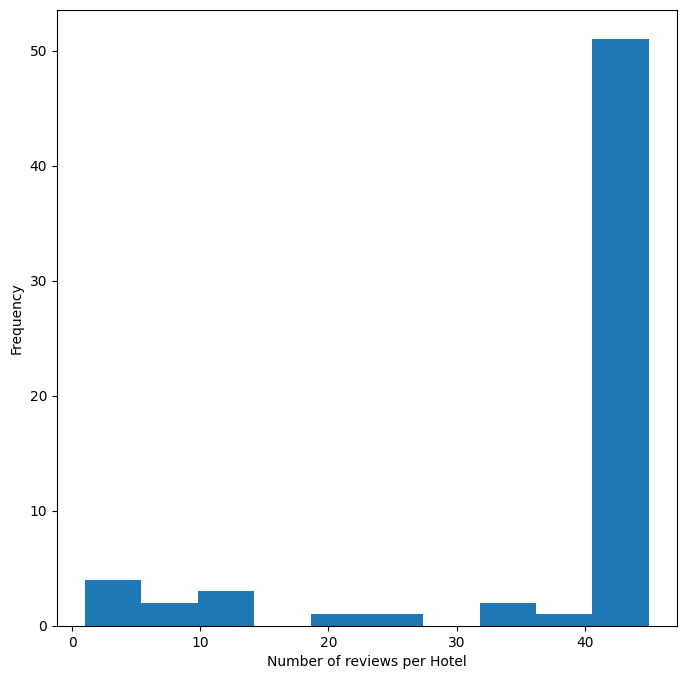

In [16]:
# Number of Hotels
reviews_per_hotel_df = miami_df["name"].value_counts(dropna=False)
logger.info(reviews_per_hotel_df)

ax = reviews_per_hotel_df.plot(kind="hist", figsize=(8, 8))
ax.set_xlabel("Number of reviews per Hotel")

This shows that the majority of hotels have between `30` to `50` reviews each, with some other hotels just having a few reviews. This is an example of an unbalanced dataset in terms of number of reviews per hotel.

# Semantic Search on all Hotels

This sections deals with creating a Search Engine that is able to identify the reviews that closely match a text query. For example, if one is trying to find a hotel that is near the beach with good customer service, the search engine will use the text embeddings of the reviews and runa cosine similarity analysis between them and the prompt to identify the best set of recommendations.

To do this, one can define a class that represents the search engine.

In [ ]:
# original
# class SemanticSearchAllHotels(object):
#     """
#     Class object for running Semantic Search on a hotel dataset.
#     """

#     def __init__(self):
#         """
#         Class object for running Semantic Search on a hotel dataset.
#         """
#         # --- Defining variables
#         # Device to use, i.e. CPU or GPU
#         self.device = self._get_device()
#         # Defining the embedder
#         self.embedder = self._get_embedder()

#         # Corpus embeddings
#         self.similarity_colname = "similarity"
#         self.embeddings_colname = "embedding"
#         self.parsed_text_colname = "combined"
#         self.corpus_dataset = None
#         self.embedding_length = 768

#     def _get_device(self) -> str:
#         """
#         Method for determining the device to use.

#         Returns
#         ----------
#         device_type : str
#             Type of device to use (e.g. 'cpu' or 'cuda').

#             Options:
#                 - ``cpu``  : Uses a CPU.
#                 - ``cuda`` : Uses a GPU.
#         """
#         # Determining the type of device to use
#         device_type = "cuda" if torch.cuda.is_available() else "cpu"

#         logger.info(f">> Running on a '{device_type.upper()}' device")

#         return device_type

#     def _get_embedder(self):
#         """
#         Method for extracting the Embedder model.

#         Returns
#         ---------
#         embedder : model
#             Variable corresponding to the Embeddings models.
#         """
#         embedder = SentenceTransformer("all-mpnet-base-v2")
#         embedder.to(self.device)

#         return embedder

#     def generate_corpus_embedding(self, corpus_dataset: pd.DataFrame):
#         """
#         Method for generating the embeddings of main corpus
#         through the enbedder.

#         Parameters
#         ------------
#         corpus_dataset : pandas.DataFrame
#             DataFrame with the text data, for which embeddings will be created.

#         Notes
#         ---------
#         This function will update the ``corpus_embeddings``
#         attribute based on the input ``corpus``.
#         """
#         logger.info(">> Generating embeddings ...")
#         # Make a copy of the dataset
#         corpus_dataset_mod = corpus_dataset.copy()
#         # Calculating the text embeddings given the input data
#         start_time = datetime.now()
#         logger.info(f">>    Started at: {start_time}")

#         corpus_dataset_mod[self.embeddings_colname] = corpus_dataset_mod[
#             self.parsed_text_colname
#         ].apply(lambda x: self.embedder.encode(x))
#         end_time = datetime.now()
#         logger.info(f">>    Ended at: {end_time}")
#         # Updating the corpus embeddings
#         self.corpus_dataset = corpus_dataset_mod.copy()

#         logger.info(
#             ">>   Corpus embeddings updated! [Took: {}]".format(
#                 end_time - start_time
#             )
#         )
#         logger.info(">> Generating embeddings ... Finished!")

#     def search_reviews(
#         self,
#         query: str,
#         top_n: Optional[int] = 10,
#         max_number_reviews_per_hotel: Optional[int] = 3,
#     ) -> List:
#         """
#         Method for running a semantic search on a query after having created the
#         corpus of the text embeddings.

#         Parameters
#         --------------
#         query : str
#             Text query to use for searching the database.

#         top_n : int, optional
#             Variable corresponding to the 'Top N' values to return based on the
#             similarity score between the input query and the corpus. This
#             variable is set to ``10`` by default.

#         max_number_reviews_per_hotel : int, optional
#             Maximum number of reviews per hotel to return for a given hotel.
#             This variable is set to ``3`` by default.

#         Returns
#         ---------
#         match_results : list
#             List containing the results of the Top-N hotels that match the
#             input query the closest. This variable incldues metadata such as
#             the name of the hotel, the score, rating, and any relevant review.
#         """
#         if self.corpus_dataset is None:
#             msg = ">>> You must first run 'generate_corpus_embedding' method!"
#             logger.error(msg)
#             raise ValueError(msg)
#         # -- Encode tthe input query and extract embeddings
#         query_embedding = self.embedder.encode(query)

#         # Compute similarity between the query embedding and the
#         # corpus embeddings
#         self.corpus_dataset.loc[
#             :, self.similarity_colname
#         ] = self.corpus_dataset[self.embeddings_colname].apply(
#             lambda x: cosine_similarity(
#                 x, query_embedding.reshape(self.embedding_length, -1)
#             )
#         )

#         # Rank results based on the similarity score
#         ranked_results = self.corpus_dataset.sort_values(
#             by=[self.similarity_colname], ascending=False
#         ).head(top_n)

#         # --- Compiling the metadata for the Top-N results.
#         # NOTE: We will be keeping track of which hotels are at the top in terms
#         # of similarity score, since we only want to return 1 review per hotel.
#         # For example, if the top 2 reviews are about the same hotel, we do not
#         # want to return both, but we want to move on to the next hotel.
#         hotel_list = []
#         match_results = []

#         # Looping over each result
#         for result_idx in ranked_results.index:
#             hotel_name = ranked_results.loc[result_idx, "name"]
#             # Checking if htoel name has been observed before
#             if hotel_name not in hotel_list:
#                 # Querying the hotels with the same name
#                 df = ranked_results.loc[ranked_results["name"] == hotel_name]
#                 # Only keeping the necessary number of reviews per hotel
#                 dataset_limited = df.iloc[:max_number_reviews_per_hotel]

#                 # Defining output variables
#                 score = str(
#                     np.round(
#                         dataset_limited.loc[
#                             result_idx,
#                             self.similarity_colname,
#                         ][0],
#                         5,
#                     )
#                 )
#                 rating = dataset_limited["rating"].max()
#                 relevant_reviews = [
#                     dataset_limited["review"][s] for s in dataset_limited.index
#                 ]

#                 # Creating output result
#                 match_results.append(
#                     {
#                         "name": hotel_name,
#                         "score": score,
#                         "rating": rating,
#                         "relevant_reviews": relevant_reviews,
#                         "n_reviews": len(relevant_reviews)
#                     }
#                 )
#                 # Adding the hotel to the list since it has already been observed
#                 hotel_list.append(hotel_name)

#         return match_results


In [49]:
class SemanticSearchAllHotels(object):
    """
    Class object for running Semantic Search on a hotel dataset.
    """

    def __init__(self):
        """
        Class object for running Semantic Search on a hotel dataset.
        """
        # --- Defining variables
        # Device to use, i.e. CPU or GPU
        self.device = self._get_device()
        # Defining the embedder
        self.embedder = self._get_embedder()

        # Corpus embeddings
        self.similarity_colname = "similarity"
        self.embeddings_colname = "embedding"
        self.parsed_text_colname = "combined"
        self.corpus_dataset = None
        self.embedding_length = 768

    def _get_device(self) -> str:
        """
        Method for determining the device to use.

        Returns
        ----------
        device_type : str
            Type of device to use (e.g. 'cpu' or 'cuda').

            Options:
                - ``cpu``  : Uses a CPU.
                - ``cuda`` : Uses a GPU.
        """
        # Determining the type of device to use
        device_type = "cuda" if torch.cuda.is_available() else "cpu"

        logger.info(f">> Running on a '{device_type.upper()}' device")

        return device_type

    def _get_embedder(self):
        """
        Method for extracting the Embedder model.

        Returns
        ---------
        embedder : model
            Variable corresponding to the Embeddings models.
        """
        embedder = SentenceTransformer("all-mpnet-base-v2")
        embedder.to(self.device)

        return embedder

    def generate_corpus_embedding(self, corpus_dataset: pd.DataFrame):
        """
        Method for generating the embeddings of main corpus
        through the enbedder.

        Parameters
        ------------
        corpus_dataset : pandas.DataFrame
            DataFrame with the text data, for which embeddings will be created.

        Notes
        ---------
        This function will update the ``corpus_embeddings``
        attribute based on the input ``corpus``.
        """
        logger.info(">> Generating embeddings ...")
        # Make a copy of the dataset
        corpus_dataset_mod = corpus_dataset.copy()
        # Calculating the text embeddings given the input data
        start_time = datetime.now()
        logger.info(f">>    Started at: {start_time}")

        corpus_dataset_mod[self.embeddings_colname] = corpus_dataset_mod[
            self.parsed_text_colname
        ].apply(lambda x: self.embedder.encode(x))
        end_time = datetime.now()
        logger.info(f">>    Ended at: {end_time}")
        # Updating the corpus embeddings
        self.corpus_dataset = corpus_dataset_mod.copy()

        logger.info(
            ">>   Corpus embeddings updated! [Took: {}]".format(
                end_time - start_time
            )
        )
        logger.info(">> Generating embeddings ... Finished!")

    def search_reviews(
        self,
        query: str,
        top_n: Optional[int] = 10,
        max_number_reviews_per_hotel: Optional[int] = 3,
    ) -> List:
        """
        Method for running a semantic search on a query after having created the
        corpus of the text embeddings.

        Parameters
        --------------
        query : str
            Text query to use for searching the database.

        top_n : int, optional
            Variable corresponding to the 'Top N' values to return based on the
            similarity score between the input query and the corpus. This
            variable is set to ``10`` by default.

        max_number_reviews_per_hotel : int, optional
            Maximum number of reviews per hotel to return for a given hotel.
            This variable is set to ``3`` by default.

        Returns
        ---------
        match_results : list
            List containing the results of the Top-N hotels that match the
            input query the closest. This variable incldues metadata such as
            the name of the hotel, the score, rating, and any relevant review.
        """
        if self.corpus_dataset is None:
            msg = ">>> You must first run 'generate_corpus_embedding' method!"
            logger.error(msg)
            raise ValueError(msg)
        # -- Encode tthe input query and extract embeddings
        query_embedding = self.embedder.encode(query)

        # Compute similarity between the query embedding and the
        # corpus embeddings
        # self.corpus_dataset.loc[
        #     :, self.similarity_colname
        # ] = self.corpus_dataset[self.embeddings_colname].apply(
        #     lambda x: cosine_similarity(
        #         x, query_embedding.reshape(self.embedding_length, -1)
        #     )
        # )


        # Apply the cosine similarity calculation
        self.corpus_dataset.loc[
            :, self.similarity_colname
        ] = self.corpus_dataset[self.embeddings_colname].apply(
            lambda x: cosine_similarity(
                np.array(x).reshape(1, -1),  # Convert x to a 2D array
                query_embedding.reshape(1, -1)  # Ensure query_embedding is also 2D
            )[0, 0]  # Extract the scalar similarity value from the 1x1 matrix
        )



        # Rank results based on the similarity score
        ranked_results = self.corpus_dataset.sort_values(
            by=[self.similarity_colname], ascending=False
        ).head(top_n)

        # --- Compiling the metadata for the Top-N results.
        # NOTE: We will be keeping track of which hotels are at the top in terms
        # of similarity score, since we only want to return 1 review per hotel.
        # For example, if the top 2 reviews are about the same hotel, we do not
        # want to return both, but we want to move on to the next hotel.
        hotel_list = []
        match_results = []
        # pdb.set_trace()
        
        # Looping over each result
        for result_idx in ranked_results.index:
            hotel_name = ranked_results.loc[result_idx, "name"]
            # Checking if htoel name has been observed before
            if hotel_name not in hotel_list:
                # Querying the hotels with the same name
                df = ranked_results.loc[ranked_results["name"] == hotel_name]
                # Only keeping the necessary number of reviews per hotel
                # pdb.set_trace()
                dataset_limited = df.iloc[:max_number_reviews_per_hotel]

                # Defining output variables
                # score = str(
                #     np.round(
                #         dataset_limited.loc[
                #             result_idx,
                #             self.similarity_colname,
                #         ][0],
                #         5,
                #     )
                # )



                # score = str(
                #     np.round(
                #         dataset_limited.loc[
                #             result_idx,
                #             self.similarity_colname,
                #         ],  # Removed [0]
                #         5,
                #     )
                # )

                # score = str(
                #     np.round(
                #         dataset_limited.loc[
                #             result_idx,
                #             self.similarity_colname,
                #         ],
                #         5,
                #     )
                # )
                print(f'result_idx {result_idx} self.similarity_colname {self.similarity_colname}')
                # pdb.set_trace()
                breakpoint() 
                score = str(
                    np.round(
                        dataset_limited.loc[
                            result_idx,
                            self.similarity_colname,
                        ],  # Ensure this returns a scalar and remove [0]
                        5,
                    )
                )


                rating = dataset_limited["rating"].max()
                relevant_reviews = [
                    dataset_limited["review"][s] for s in dataset_limited.index
                ]

                # Creating output result
                match_results.append(
                    {
                        "name": hotel_name,
                        "score": score,
                        "rating": rating,
                        "relevant_reviews": relevant_reviews,
                        "n_reviews": len(relevant_reviews)
                    }
                )
                # Adding the hotel to the list since it has already been observed
                hotel_list.append(hotel_name)

        return match_results


Now that we've defined the class that will deal with the search engine, we can create the corpus embeddings based on the hotels dataset and test the search engine with a prompt:

In [52]:
# Instantiating the Search Engine class
search_engine_all_hotels_obj = SemanticSearchAllHotels()

2024-11-07 09:23:07,081 [INFO]: >> Running on a 'CPU' device
2024-11-07 09:23:07,089 [INFO]: Use pytorch device_name: cpu
2024-11-07 09:23:07,090 [INFO]: Load pretrained SentenceTransformer: all-mpnet-base-v2


Next, we build the embeddings for the corpus using the hotels dataset:

In [53]:
# Use the clean dataset to create the corpus embeddings
search_engine_all_hotels_obj.generate_corpus_embedding(corpus_dataset=clean_dataset)

2024-11-07 09:23:12,208 [INFO]: >> Generating embeddings ...
2024-11-07 09:23:12,214 [INFO]: >>    Started at: 2024-11-07 09:23:12.214596
Batches: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]
2024-11-07 09:28:28,065 [INFO]: >>    Ended at: 2024-11-07 09:28:28.065163
2024-11-07 09:28:28,069 [INFO]: >>   Corpus embeddings updated! [Took: 0:05:15.850567]
2024-11-07 09:28:28,070 [INFO]: >> Generating embeddings ... Finished!


We can check that the embeddings are correctly stored within the Search Engine:

In [ ]:
search_engine_all_hotels_obj.corpus_dataset.head()

,category,address,email,id,name,numberOfReviews,numberOfRooms,priceLevel,rankingPosition,rating,title,review,webUrl,hotelClass,priceMin,priceMax,combined,embedding
0,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,My favorite hotel in Miami--Petar is the best!,Hands down my absolute favorite hotel in South...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title favorite hotel miamipetar best content h...,"[-0.01647297, -0.018178543, 0.0051879375, 0.00..."
1,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Exquisite Stay,There are not enough words to explain the sump...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title exquisite stay content words explain sum...,"[0.009218823, 0.008275815, -0.022674587, 0.071..."
2,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Burlesqu Show,I went for the Burlesque show which was absolu...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title burlesqu content went burlesque absolute...,"[0.045623966, 0.06304609, 0.01060311, -0.02232..."
3,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Dana at Gitano is a rockstar!,Dana at Gitano made the night magical! He make...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title dana gitano rockstar content dana gitano...,"[0.048349082, 0.042063955, -0.013546425, 0.024..."
4,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Perfect Place,I would like to give our very very heartfelt t...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title perfect place content like heartfelt tha...,"[0.017001601, 0.027189666, -0.015903773, 0.025..."


The final step for checking the Semantic Search Engine is to use a query to get the Top-N results

In [54]:
# Defining the input query to use
query = """
Hotels in miami that are close to a Sushi bar
"""

# Searching for the Top-5 hotels
top_n_results = search_engine_all_hotels_obj.search_reviews(
    query=query,
    top_n=3,
    max_number_reviews_per_hotel=4,
)

top_n_results

Batches: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


result_idx 1635 self.similarity_colname similarity
result_idx 1890 self.similarity_colname similarity
result_idx 1382 self.similarity_colname similarity


[{'name': 'Kasa El Paseo Miami Beach',
  'score': '0.64124',
  'rating': np.float64(4.5),
  'relevant_reviews': ['This hotel is the best! It is a boutique hotel that sits smack dab in the middle of the busiest party street on south beach so you wouldn’t know how clean the hotel is, how courteous and how accommodating the staff is unless you saw it for yourself.\n\nWe had a room with a balcony that overlooked Española Way, which was clutch!\n\nWhen we were ready to party but remain in the comfort of our room, we just stepped out onto our balcony. If we wanted to take a stroll on the beach, we were just a few short blocks away, if we wanted to party, we were a quick Uber ride away from a myriad of SOBE hot spots, and if we wanted to grab a bite to eat, we could just walk downstairs and grab some really good Cuban food.\n\nI mean…. This place has everything you’d want in a getaway weekend and more! I would totally recommend this hotel to anyone coming to Miami for the first or even for th

In [55]:
clean_dataset.head()

,category,address,email,id,name,numberOfReviews,numberOfRooms,priceLevel,rankingPosition,rating,title,review,webUrl,hotelClass,priceMin,priceMax,combined
0,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,My favorite hotel in Miami--Petar is the best!,Hands down my absolute favorite hotel in South...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title favorite hotel miamipetar best content h...
1,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Exquisite Stay,There are not enough words to explain the sump...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title exquisite stay content words explain sum...
2,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Burlesqu Show,I went for the Burlesque show which was absolu...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title burlesqu content went burlesque absolute...
3,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Dana at Gitano is a rockstar!,Dana at Gitano made the night magical! He make...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title dana gitano rockstar content dana gitano...
4,hotel,"3201 Collins Ave Faena District, Miami Beach, ...",reservations-miamibeach@faena.com,7787044,Faena Miami Beach,2123,179,$$$$,5,4.5,Perfect Place,I would like to give our very very heartfelt t...,https://www.tripadvisor.com/Hotel_Review-g3443...,0.0,729,1426,title perfect place content like heartfelt tha...


# API for Semantic Search Engine for All Hotels

The following is a simple app that will return the Top-5 elements for a given search.

In [56]:
# Defining the function to use
def perform_search_app(query: str):
    """
    Function to run the Semantic Search on the Miami Hotels dataset.
    This function will return the top 10 elements.

    Parameters
    ------------
    query : str
        Query to feed to the search engine.

    Returns
    -----------
    top_n_results : list
        Variables corresponding to the list of results in JSON format.
    """

    top_n =  search_engine_all_hotels_obj.search_reviews(
        query=query,
        top_n=10,
        max_number_reviews_per_hotel=4,
    )

    return top_n

demo = gr.Interface(fn=perform_search_app, inputs="text", outputs="json")

demo.launch(share=True, debug=True)

2024-11-07 09:38:04,294 [INFO]: HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7860


2024-11-07 09:38:05,918 [INFO]: HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
2024-11-07 09:38:05,994 [INFO]: HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"
2024-11-07 09:38:06,434 [INFO]: HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"
2024-11-07 09:38:06,976 [INFO]: HTTP Request: GET https://cdn-media.huggingface.co/frpc-gradio-0.3/frpc_windows_amd64.exe "HTTP/1.1 200 OK"


* Running on public URL: https://7fe294d3af75dd38d9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


2024-11-07 09:38:14,386 [INFO]: HTTP Request: HEAD https://7fe294d3af75dd38d9.gradio.live "HTTP/1.1 200 OK"


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


result_idx 1201 self.similarity_colname similarity
result_idx 374 self.similarity_colname similarity
result_idx 2002 self.similarity_colname similarity
result_idx 1251 self.similarity_colname similarity
result_idx 103 self.similarity_colname similarity
result_idx 1795 self.similarity_colname similarity
result_idx 2133 self.similarity_colname similarity
result_idx 315 self.similarity_colname similarity
result_idx 463 self.similarity_colname similarity
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7fe294d3af75dd38d9.gradio.live


# Generating summaries for each Hotel using GPT-3

The following section will deal with the creation of a dataset that summarizes each hotel based on the reviews from the "cleaned" dataset.

We will defined a function class to generate this dataset.

In [68]:
# !pip install python-dotenv
# import os
from dotenv import load_dotenv
import os

load_dotenv()
# Read the OpenAI API key from environment variables
api_key = os.getenv("OPENAI_API_KEY")

if api_key:
    print("API Key read successfully!")
else:
    print("API Key not found. Please set the OPENAI_API_KEY environment variable.")


API Key read successfully!


In [69]:
# Initializing Hotel Summarizer object
hotel_summarizer_obj = HotelSummarizer(dataset=clean_dataset)

In [70]:
# Creating the summaries for each hotel
hotel_summaries_df = hotel_summarizer_obj.run_summary(save_to_disk=True)

2024-11-08 00:22:01,519 [INFO]: Majestic Hotel South Beach using '26' reviews out of '45' for summary generation


2024-11-08 00:22:04,305 [INFO]: 

Hotel name: Majestic Hotel South Beach
Hotel class: 3.0 stars 
Price range: $134 - $244
Price level: $$Address: 660 Ocean Dr, Miami Beach, FL 33139-6219
Reservations email: info@majesticsouthbeach.com
Website: https://www.tripadvisor.com/Hotel_Review-g34439-d1011427-Reviews-Majestic_Hotel_South_Beach-Miami_Beach_Florida.html
Rating: 3.5

The hotel in Miami received an average rating of 3.5. Guests mentioned positive aspects such as the excellent location, friendly staff, comfortable beds, and good food at the restaurant. However, some guests complained about cleanliness issues, noise disturbances, limited room amenities, and unprofessional behavior from certain staff members. Positive comments highlighted the hotel's proximity to the beach, the convenience of on-site dining options, and the overall pleasant atmosphere. On the other hand, negative feedback focused on issues like room cleanliness, noise levels, and unmet expectations regarding room views

KeyboardInterrupt: 

In [ ]:
# Reading in data
hotel_summaries_df = pd.read_csv("datasets/hotel_summaries.csv")

hotel_summaries_df.head()

,id,name,summary
0,7787044,Faena Miami Beach,Hotel name: Faena Miami Beach\nPrice level: $$...
1,7606777,1 Hotel South Beach,Hotel name: 1 Hotel South Beach\nHotel class: ...
2,111904,The Kent Hotel,Hotel name: The Kent Hotel\nHotel class: 3.0 s...
3,23093311,The Goodtime Hotel,Hotel name: The Goodtime Hotel\nHotel class: 3...
4,1175532,The Betsy South Beach,Hotel name: The Betsy South Beach\nHotel class...


# Semantic Search on the Hotels Summary dataset

This sections deals with doing a semantic search on a the Hotels Summary dataset. This will perform a search on the dataset given a query and return the set of hotels that closely match the input query.

In [58]:
# Defining the class that will handle the summary generation for each Hotel using ChatGPT


class HotelSummarizer(object):
    """
    Class object for summarizing hotels based on user reviews.
    """

    def __init__(self, dataset: pd.DataFrame, **kwargs):
        """
        Class definition of the ``Hotel Summarizer``.

        Parameters
        -----------
        dataset : pandas.DataFrame
            Dataset containing the metadata about different hotels, as well as
            their corresponding user reviews.

        model : str, optional
            Name of the model to use to create the summary of the dataset.
            This variable is set to ``gpt-3.5-turbo`` by default.

        max_tokens : int, optional
            Maximum number of tokens to use when summarizing the dataset.
            This variable is set to ``4096`` by default.

        result_tokens : int, optional
            Number of tokens to retrieve when summarizing the dataset. This
            variable is set to ``300`` by default.
        """
        # Defining data directory
        self.datasets_dir = Path().resolve().joinpath("datasets")
        # Input dataset
        self.dataset = dataset.copy()
        # Defining class attributes
        self.openai_endpoint = "https://api.openai.com/v1/chat/completions"

        # Prompt template
        self.prompt_template = self._get_prompt_template()

        # Type of model to use
        self.model = kwargs.get("model", "gpt-3.5-turbo")

        # Model hyperparameters
        self.max_tokens = kwargs.get("max_tokens", 4096)
        self.result_tokens = kwargs.get("result_tokens", 300)

        # Model encoding
        self.model_encoding = self._get_model_encoding()

        # Token length of the prompt template
        self.prompt_token_length = self._get_number_of_tokens(
            self.prompt_template
        )

    def _get_prompt_template(self) -> str:
        """
        Method for extracting the prompt template to use when feeding the data
        to ChatGPT.

        Returns
        -----------
        prompt_template : str
            Template to use when feeding the data to ChatGPT.
        """
        # Defining the template to use
        template_text = """
    Create a concise, clear, and in-depth summary of the following reviews of a
    hotel in Miami, Adher to these guidelines:

    1. Include the average rating.
    2. Sound professional, detached and avoid emotionally charged language.
    3. Make sure to mention some positive and negative experiences discussed
    in guest reviews in the summary
    4. The summary should be between one and three paragraphs.
    """

        return template_text

    def _get_model_encoding(self):
        """
        Method for extractiang the encoding for the specified model.

        Returns
        ---------
        model_encoding :
            Encodings of the input model.
        """

        return tiktoken.encoding_for_model(self.model)

    def _get_number_of_tokens(self, input_text: str) -> int:
        """
        Method for determining the number of tokens of the input text.

        Parameters
        -----------
        input_text : str
            Text to use for calculating its token length.

        Returns
        ---------
        text_token_length : int
            Lenght of the tokens of the input text.
        """

        return len(self.model_encoding.encode(input_text))

    def _parse_dataset(self) -> pd.DataFrame:
        """
        Method for parsing the dataset and convert into a data format that can
        easily be used with the ``model``.

        Returns
        ----------
        parsed_dataset : pandas.DataFrame
            Parsed version of the input dataset.
        """
        # Copy of the input dataset
        dataset = self.dataset.copy()
        # Defining variables
        reviews_colname = "review"
        # -- Shuffling the dataset first
        dataset = dataset.sample(frac=1).reset_index(drop=True)
        # --- Creating custom string for each individual object in the dataset

    def _run_model(
        self,
        user_content: str,
        temperature: Optional[int] = 1,
    ):
        """
        Method for running the model that will create the summary for a given
        observation.

        Parameters
        ------------
        user_content : str
            Content by the user that will be sent to the model via its API.

        temperature : float, optional
            Amount of ``temperature`` to give to the model. This parameter
            handles the amount of creativity that the model can have when
            creating the output response. This variable is set to ``1`` by
            default.

        Returns
        ----------
        """
        # Creating the headers
        headers = {
            "Content-Type": "application/json",
            "Authorization": f'Bearer {os.environ["OPENAI_API_KEY"]}',
        }
        # Composing the input messages
        messages = [
            {"role": "system", "content": self.prompt_template},
            {"role": "user", "content": user_content},
        ]
        # Parsing the request data
        request_data = {
            "model": self.model,
            "messages": messages,
            "temperature": temperature,
        }
        # Extracting the response from the model's API
        response = requests.post(
            self.openai_endpoint,
            headers=headers,
            data=json.dumps(request_data),
        )

        # Checkig if the response was OK
        if response.status_code == 200:
            return response.json()["choices"][0]["message"]["content"]
        else:
            raise RuntimeError(
                f"HTTP request failed code {response.status_code}, {response.text}"
            )

    def _summary_single_observation(
        self,
        hotel_id: str,
        dataset: pd.DataFrame,
        summary_data: List,
    ):
        """
        Method for running the summary implementation for a single hotel.

        Parameters
        ------------
        hotel_id : str
            ID corresponding to the hotel.

        dataset : pandas.DataFrame
            Dataset with all of the hotel's metadata and user reviews.

        summary_data : list
            List containing the summary results for each hotel.
        """
        # Defining variables
        hotel_name = dataset["name"].unique()[0]
        total_number_reviews_per_hotel = len(dataset)
        hotel_class = dataset["hotelClass"].unique()[0]
        price_minimum = dataset["priceMin"].unique()[0]
        price_maximum = dataset["priceMax"].unique()[0]
        hotel_price_level = dataset["priceLevel"].unique()[0]
        hotel_email = dataset["email"].unique()[0]
        hotel_website = dataset["webUrl"].unique()[0]
        hotel_address = dataset["address"].unique()[0]
        hotel_rating = dataset["rating"].unique()[0]
        # --- Shuffling the order of the reviews for the specified hotel
        dataset = dataset.sample(frac=1).reset_index(drop=True)

        # --- Defining the variable that will be fed to the model
        hotel_reviews_obj = ""
        number_reviews_used = 0
        total_tokens = self.prompt_token_length

        # Looping over each review and parsing the text
        for _, review_df in dataset.iterrows():
            # Parsing the data from the
            review_str = "Rating: {}\n{}\n\{}\n\n".format(
                review_df["rating"], review_df["title"], review_df["review"]
            )
            # Calculating the token length of the variable
            review_token_length = self._get_number_of_tokens(
                input_text=review_str
            )
            # Check that the token length is within the allowable limit
            if (total_tokens + review_token_length) < (
                self.max_tokens - self.result_tokens
            ):
                hotel_reviews_obj += review_str
                total_tokens += review_token_length
                number_reviews_used += 1
            else:
                break

        # --- Submitting results to the model
        logger.info(
            "{} using '{}' reviews out of '{}' for summary generation".format(
                hotel_name, number_reviews_used, total_number_reviews_per_hotel
            )
        )
        # Submitting model request
        try:
            summary_result = self._run_model(user_content=hotel_reviews_obj)
        except RuntimeError as e:
            logger.warning(e)
            logger.warning("Retrying the last submission")

            return None, None

        # --- Constructing the summary of the hotel
        summary_text = f"Hotel name: {hotel_name}\n"

        # Checking the hotel class, if applicable
        if hotel_class > 0:
            summary_text += f"Hotel class: {hotel_class} stars \n"
        summary_text += f"Price range: ${price_minimum} - ${price_maximum}\n"
        summary_text += f"Price level: {hotel_price_level}"
        summary_text += f"Address: {hotel_address}\n"

        if isinstance(hotel_email, str):
            summary_text += f"Reservations email: {hotel_email}\n"
        if isinstance(hotel_website, str):
            summary_text += f"Website: {hotel_website}\n"
        summary_text += f"Rating: {hotel_rating}\n\n"

        # Appending the output summary from the model
        summary_text += f"{summary_result}\n"

        logger.info(f"\n\n{summary_text}")

        # Appending data to the main output list
        summary_data.append([hotel_id, hotel_name, summary_text])

        return

    def run_summary(self, save_to_disk: Optional[bool] = True) -> pd.DataFrame:
        """
        Method for running the summarization method on each aspect of the dataset.

        Parameters
        -----------
        save_to_disk : bool, optional
            If ``True``, the output dataset will be saved to disk. This
            variable is set to ``True`` by default.

        Returns
        ---------
        summary_dataset : pandas.DataFrame
            Dataset containing the summary of each hotel along with the
            hotel's metadata.
        """
        # --- Parsing the dataset
        # Hotel ID column name
        hotel_colname = "id"
        summary_data = []
        # Grouping by each hotel
        for hotel_id, hotel_dataset in self.dataset.groupby(
            by=[hotel_colname]
        ):
            # Looping for just one asset
            self._summary_single_observation(
                hotel_id=hotel_id,
                dataset=hotel_dataset,
                summary_data=summary_data,
            )

        # Creating dataset
        summary_df = pd.DataFrame(
            summary_data, columns=["id", "name", "summary"]
        )

        # Saving to disk, if applicable
        if save_to_disk:
            # Filepath
            filepath = Path(self.datasets_dir).joinpath("hotel_summaries.csv")
            filepath.parent.mkdir(parents=True, exist_ok=True)
            summary_df.to_csv(filepath, header=True, index=True)

            logger.info(f">> Hotel Summaries saved to '{str(filepath)}'")

        return summary_df


In [ ]:
class SemanticSearchHotelsSummary(object):
    """
    Class object for running Semantic Search on a hotel summary dataset.
    """

    def __init__(self):
        """
        Class object for running Semantic Search on a hotel summary dataset.
        """
        # --- Defining variables
        # Device to use, i.e. CPU or GPU
        self.device = self._get_device()
        # Embedder model to use
        self.model = "paraphrase-mpnet-base-v2"
        # Defining the embedder
        self.embedder = self._get_embedder()

        # Corpus embeddings
        self.faiss_index = None
        self.corpus_dataset = None
        self.source_colname = "summary"

    def _get_device(self) -> str:
        """
        Method for determining the device to use.

        Returns
        ----------
        device_type : str
            Type of device to use (e.g. 'cpu' or 'cuda').

            Options:
                - ``cpu``  : Uses a CPU.
                - ``cuda`` : Uses a GPU.
        """
        # Determining the type of device to use
        device_type = "cuda" if torch.cuda.is_available() else "cpu"

        logger.info(f">> Running on a '{device_type.upper()}' device")

        return device_type

    def _get_embedder(self):
        """
        Method for extracting the Embedder model.

        Returns
        ---------
        embedder : model
            Variable corresponding to the Embeddings models.
        """
        embedder = SentenceTransformer(self.model)
        embedder.to(self.device)

        return embedder

    def generate_corpus_index_and_embeddings(
        self,
        corpus_dataset: pd.DataFrame,
    ):
        """
        Method for generating the text embeddings and FAISS indices from
        the input dataset.

        Parameters
        -------------
        corpus_dataset : pandas.DataFrame
            DataFrame containing the text to use to create the text embeddings
            and FAISS indices.

        Returns
        ----------
        faiss_index :
            FAISS indices that correspond to the text embeddings of the
            input dataset.
        """
        logger.info(">> Generating embeddings and FAISS indices ...")
        # --- Computing the text embeddings of the data
        start_time = datetime.now()
        logger.info(f">>    Started at: {start_time}")
        # Getting the embeddings of the source text
        corpus_embeddings = self.embedder.encode(
            corpus_dataset[self.source_colname].copy()
        )
        # Extracting the embeddings' dimension
        embedding_dimension = corpus_embeddings.shape[1]
        # Calculating the FAISS indices
        faiss_index = faiss.IndexFlatL2(embedding_dimension)
        # Normalizing the FAISS indices
        faiss.normalize_L2(corpus_embeddings)
        # Adding the embeddings to the FAISS index
        faiss_index.add(corpus_embeddings)

        # Updating the corpus dataset and FAISS index
        self.corpus_dataset = corpus_dataset.copy()
        self.faiss_index = faiss_index

        end_time = datetime.now()
        logger.info(f">>    Ended at: {end_time}")
        logger.info(f">>    Took: {end_time - start_time}")

        logger.info(">> Generating embeddings and FAISS indices ... Done")

    def _parse_semenatic_results(self, semantic_result: str) -> Dict:
        """
        Method for parsing a single output from the semantic search.

        Parameters
        ------------
        semantic_result : str
            Variable corresponding to the output result from running
            semantic search on the hotel summaries.

        Returns
        -----------
        parsed_result : dict
            Dictionary containing the parsed data from ``semantic_result``.
            This variable will have the individual sections of the
            results identified and labeled.
        """
        # Splitting between description and the hotel's metadata
        hotel_metadata, hotel_summary = semantic_result.split("\n\n")
        # Differentiating between the many of the hotel's metadata
        hotel_metadata_dict = {
            record.split(":")[0]
            .strip(): "".join(record.split(":")[1:])
            .strip()
            for record in hotel_metadata.split("\n")
        }
        hotel_metadata_dict["Hotel Summary"] = hotel_summary

        return hotel_metadata_dict

    def semantic_search(
        self,
        query: str,
        top_n: Optional[int] = 10,
    ) -> List:
        """
        Method for running a semantic search on a query after having created the
        corpus of the text embeddings.

        Parameters
        --------------
        query : str
            Text query to use for searching the database.

        top_n : int, optional
            Variable corresponding to the 'Top N' values to return based on the
            similarity score between the input query and the corpus. This
            variable is set to ``10`` by default.

        Returns
        ---------
        match_results : list
            List containing the results of the Top-N hotels that match the
            input query the closest. This variable incldues metadata such as
            the name of the hotel, the score, rating, and any other
            relavant info.
        """
        # --- Checking that the encoder has been indexed correctly
        if (self.corpus_dataset is None) or (self.faiss_index is None):
            msg = ">>> You must first run 'generate_corpus_embedding' method!"
            logger.error(msg)
            raise ValueError(msg)

        # --- Encode the input query and extract the embeddings
        query_embedding = self.embedder.encode(query)

        # --- Computing the L2 distances using FAISS
        # Converting the embeddings into an array
        _query_embedding_vector = np.asarray([query_embedding])
        # Normalizing the FAISS index
        faiss.normalize_L2(_query_embedding_vector)
        # Total number of indexed vectors
        n_vectors = self.faiss_index.ntotal
        # Computing the distances and extract their distances and ann indices
        distances, ann = self.faiss_index.search(
            _query_embedding_vector,
            k=n_vectors,
        )

        # --- Parsing results
        results = pd.DataFrame({"distances": distances[0], "ann": ann[0]})
        # Combining the data with the main dataset
        merged_dataset = pd.merge(
            left=results,
            right=self.corpus_dataset.copy(),
            left_on="ann",
            right_index=True,
        )

        # -- Creating payload to return by the method
        match_results = [
            self._parse_semenatic_results(x)
            for x in merged_dataset[self.source_colname][:top_n].tolist()
        ]

        return match_results


We will now initialize the class definition to run Semantic Search on the dataset with Hotel Summaries:

In [ ]:
# Initializing Semantic Search object for Hotel Summaries
semantic_search_hotel_summaries_obj = SemanticSearchHotelsSummary()

INFO:__main__:>> Running on a 'CUDA' device


In [ ]:
# Generate the corpus of the search engine
semantic_search_hotel_summaries_obj.generate_corpus_index_and_embeddings(
    corpus_dataset=hotel_summaries_df
)

INFO:__main__:>> Generating embeddings and FAISS indices ...
INFO:__main__:>>    Started at: 2023-06-12 12:22:20.721344
INFO:__main__:>>    Ended at: 2023-06-12 12:22:21.820608
INFO:__main__:>>    Took: 0:00:01.099264
INFO:__main__:>> Generating embeddings and FAISS indices ... Done


In [ ]:
# Test the search engine on a query
query = """
A hotel close to restaurants and a good vibe
"""

results = semantic_search_hotel_summaries_obj.semantic_search(
    query=query,
    top_n=3,
)

results

[{'Hotel name': 'Hilton Grand Vacations Club McAlpin Ocean Plaza Miami',
  'Hotel class': '4.0 stars',
  'Price level': '$$$$',
  'Price range': '$450',
  'Address': '1430 Ocean Drive, Miami Beach, FL 33139',
  'Reservations email': 'rentalsales@hgvc.com',
  'Website': 'https//www.hilton.com/en/hotels/miamsgv-hilton-grand-vacations-club-mcalpin-ocean-plaza-miami/?SEO_id=YEXTN-GV-MIAMSGV&y_source=1_Mjc3Mjk0MjMtNzY5LWxvY2F0aW9uLndlYnNpdGU%3D',
  'Ranking': '#38 of 235 hotels in Miami Beach',
  'Hotel Summary': 'The Hilton Grand Vacations on McAlpin - Ocean Plaza in Miami is generally well-liked. Its central South Beach location, right across from the beach and within walking distance to many restaurants and shops, is particularly praised, as is the friendly and welcoming staff. Some guests comment that the hotel has a historic feel and could use some updating. Additionally, some guests mention that the street closure makes unloading and parking a bit tricky. The rooftop hot tub is a plus

# API Development for Semantic Search on Hotel Summaries

The following is an API that can retrieve search results using Semantic Search using a dataset comprised of hotel's metadata and the corresponding hotel summary.

In [ ]:
# Defining the function to use
def perform_semantic_search_hotel_summaries_app(query: str):
    """
    Function to run the Semantic Search on the dataset of Miami Hotels
    and their corresponding summaries.
    This function will return the top 10 elements.

    Parameters
    ------------
    query : str
        Query to feed to the search engine.

    Returns
    -----------
    top_n_results : list
        Variables corresponding to the list of results in JSON format.
    """

    top_n = semantic_search_hotel_summaries_obj.semantic_search(
        query=query,
        top_n=10,
    )

    return top_n


demo = gr.Interface(
    fn=perform_semantic_search_hotel_summaries_app,
    inputs="text",
    outputs="json",
)

demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://8dc59549c57c1bb979.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8dc59549c57c1bb979.gradio.live


# Multi-Service Application

The following is an API that can handle both types of Semantic Search modes, i.e. one using the entire hotel datasets and their reviews, and the other using the hotel summaries as the backbone of the service.

This app is made using `gradio`, which enables us to deploy the API:

In [ ]:
# --- Defining the methods to use
# Semantic Search - Entire dataset + Reviews
def perform_semantic_search_hotel_reviews_app(query: str):
    """
    Function to run the Semantic Search on the dataset of Miami Hotels
    and their corresponding summaries.
    This function will return the top 10 elements.

    Parameters
    ------------
    query : str
        Query to feed to the search engine.

    Returns
    -----------
    top_n_results : list
        Variables corresponding to the list of results in JSON format.
    """

    top_n = search_engine_all_hotels_obj.search_reviews(
        query=query,
        top_n=10,
        max_number_reviews_per_hotel=4,
    )

    return top_n


# Semantic Search - Entire Dataset but using Hotel Summaries instead
def perform_semantic_search_hotel_summaries_app(query: str):
    """
    Function to run the Semantic Search on the dataset of Miami Hotels
    and their corresponding summaries.
    This function will return the top 10 elements.

    Parameters
    ------------
    query : str
        Query to feed to the search engine.

    Returns
    -----------
    top_n_results : list
        Variables corresponding to the list of results in JSON format.
    """

    top_n = semantic_search_hotel_summaries_obj.semantic_search(
        query=query,
        top_n=10,
    )

    return top_n


# --- Defining the Gradio components

# Semantic Search - Entire dataset + Reviews
semantic_search_hotel_reviews = gr.Interface(
    fn=perform_semantic_search_hotel_reviews_app,
    inputs="text",
    outputs="json",
)

# Semantic Search - Entire Dataset but using Hotel Summaries instead
semantic_search_hotel_summaries = gr.Interface(
    fn=perform_semantic_search_hotel_summaries_app,
    inputs="text",
    outputs="json",
)

# App combining both services
semantic_search_general_app = gr.TabbedInterface(
    [semantic_search_hotel_reviews, semantic_search_hotel_summaries],
    ["Semantic Search - Hotel Reviews", "Semantic Search - Hotel Summaries"],
)


semantic_search_general_app.launch(
    share=True,
    debug=True,
)


/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:919: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://8b392369d6e0bb6b3e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8b392369d6e0bb6b3e.gradio.live


# Aspect-Based Sentiment Analysis

This section focuses on the the analysis of a single hotel. We'll be running [Aspect-based Sentiment Analysis][absa_medium_article] (ABSA) on the data for the hote to better understand it.

The main idea is that one is able to extract sentiments and aspects from the text.

<!-- Link -->

[absa_medium_article]: https://medium.com/nlplanet/quick-intro-to-aspect-based-sentiment-analysis-c8888a09eda7

In [ ]:
class AbsaAnalyzer(object):
    """
    Class definition for the Aspect-based Sentiment Analysis
    """

    def __init__(self):
        """
        Class definition for the Aspect-based Sentiment Analysis
        """
        # Defining data directory
        self.datasets_dir = Path().resolve().joinpath("datasets")
        # Defining class attributes
        self.model_name = "yangheng/deberta-v3-base-absa-v1.1"
        self.source_colname = "summary"

        # Extracting the aspects to use in the analysis
        self.aspects = self._get_aspects()

        # Tokenizer and model
        self.model = self._get_model()
        self.tokenizer = self._get_tokenizer()

        # Data preparation
        self.batch_size = 64
        self.batches = None
        self.model_inputs = None
        self.dataset = None
        self.n_summaries = None
        self.hotel_names = None

    def _get_tokenizer(self):
        """
        Method for extracting the tokenizer of the application.

        Returns
        ---------
        tokenizer_obj :
            Tokenizer of the service.
        """

        return AutoTokenizer.from_pretrained(self.model_name)

    def _get_model(self):
        """
        Method for extracting the ABSA model of the application.

        Returns
        ---------
        model :
            ABSA model object.
        """
        # Defining the model
        model_obj = AutoModelForSequenceClassification.from_pretrained(
            self.model_name
        )
        # Setting the model to evaluation mode
        model_obj.eval()

        # Compiling the model for faster inference, if applicable
        torch_version = packaging.version.parse(torch.__version__)
        if torch_version >= packaging.version.parse("2.0.0"):
            # Compiling model
            model_obj = torch.compile(
                model_obj, mode=(mode := "reduce-overhead")
            )
            logger.info(f">> Model compiled in {mode} mode!")

        return model_obj

    def _get_aspects(self) -> List:
        """
        Method for extracting the ``aspects` that are used by the model.

        Returns
        ---------
        aspects : list
            List containing the set of aspects to use when parsing the text.
        """

        return [
            "staff",
            "cleanliness",
            "comfort",
            "location",
            "value for money",
        ]

    def prepare_data(self, dataset: pd.DataFrame):
        """
        Method for executing the data preparation tasks, such as defining
        the batches and the inputs to the model.

        Parameters
        -----------
        dataset : pandas.DataFrame
            Dataset containing the summaries of each hotel.
        """
        # Extracting the text that will be used to infer ABSA
        summaries = (
            dataset[self.source_colname]
            .apply(lambda x: x.splitlines()[-1])
            .tolist()
        )
        # Number of summaries
        n_summaries = len(summaries)

        # --- Making sure that the data have the correct format for modeling
        # NOTE: Creating a list that contains copies of each summary for every
        # aspect, so that one can pass these to the model
        repeated_summaries = list(
            itertools.chain.from_iterable(
                itertools.repeat(s, len(self.aspects)) for s in summaries
            )
        )
        # Number of repeated 'aspects'
        repeated_aspects = self.aspects * n_summaries

        # Creating the batches of data to pass to the model
        batches = [
            (
                repeated_summaries[i : i + self.batch_size],
                repeated_aspects[i : i + self.batch_size],
            )
            for i in range(0, len(repeated_summaries), self.batch_size)
        ]

        # Set of inputs to the model
        model_inputs = [
            self.tokenizer(*batch, padding=True, return_tensors="pt")
            for batch in batches
        ]

        # --- Updating attributes
        self.model_inputs = model_inputs
        self.batches = batches
        self.dataset = dataset.copy()
        self.summaries = summaries
        self.n_summaries = n_summaries
        self.hotel_names = dataset["name"].unique().tolist()

    def run(
        self,
        save_to_disk: Optional[bool] = True,
    ) -> pd.DataFrame:
        """
        Method for running the 'Aspect-Based Sentiment Analysis' for the
        observations from the input dataset.

        Parameters
        ------------
        save_to_disk : bool, optional
            If ``True``, the output dataset will be saved to disk. This
            variable is set to ``True`` by default.

        Returns
        -----------
        absa_output : pandas.DataFrame
            Dataset containing the metadata of each hotel, as well as the
            score for each of the different aspects of ABSA.
        """
        logger.info(">> Running ABSA generation ...")

        # Checking that the data is available
        if (self.batches is None) or (self.model_inputs is None):
            msg = ">> You must first run 'prepare_data'!"
            logger.error(msg)
            raise ValueError(msg)

        # Calculating the scores for each set of batches
        output_tensors = []

        start_time = datetime.now()
        logger.info(f">>   Start Time: {start_time}")

        for batch_id, batch in enumerate(self.model_inputs):
            with torch.no_grad():
                # Computing the inference
                batch_output = self.model(**batch)
                logits = batch_output["logits"]
                scores = F.softmax(logits, dim=1)
                output_tensors.append(scores)

                logger.info(
                    f">>    Batch: {batch_id} finished at: {datetime.now()}"
                )

        # Concatenating the scores of all batches
        scores_all_batches = torch.cat(output_tensors)

        end_time = datetime.now()
        logger.info(f">>   End time: {end_time}")
        logger.info(f">>   Took: {end_time - start_time}")

        # --- Reshaping the scores of all batches
        # NOTE: (N x num_aspects) x num_classes -> N x num_aspects x num_classes
        scores_all_batches = scores_all_batches.reshape(
            self.n_summaries, len(self.aspects), -1
        )
        scores_all_batches = scores_all_batches.detach().numpy()

        # Extracting the labels for each 'aspect'
        label2id = {v: k for k, v in self.model.config.id2label.items()}
        positive_idx = label2id["Positive"]

        # --- Data parsing
        # Creating a DataFrame with the sentiment score for each aspect
        positive_sentiment_score = pd.DataFrame(
            scores_all_batches[..., positive_idx], columns=self.aspects
        )
        self.positive_sentiment_score = positive_sentiment_score

        # Combine the datasets into the final output
        absa_output = pd.concat(
            [self.dataset, positive_sentiment_score],
            axis=1,
        )
        self.absa_output = absa_output

        # Saving to disk, if applicable
        if save_to_disk:
            # Filepath
            output_filename = (
                "hotel_summaries_with_aspect_sentiment_scores.csv"
            )
            filepath = Path(self.datasets_dir).joinpath(output_filename)
            filepath.parent.mkdir(parents=True, exist_ok=True)

            absa_output.to_csv(filepath, header=True, index=False)

            logger.info(
                f">>   Hotel Summaries + ABSA saved to '{str(filepath)}'"
            )

        # Adding the ID for each hotel to the dataset
        absa_subset_data = absa_output[["id"] + self.aspects].set_index("id")

        # Creating baseline scores
        baseline_scores = absa_subset_data.mean(axis=0)
        absa_subset_data = absa_subset_data.apply(
            lambda x: np.maximum(x, baseline_scores), axis=1
        )

        # Saving the data as an attribute
        self.absa_subset_data = absa_subset_data

        logger.info(">> Running ABSA generation ...")

        return absa_subset_data

    def _create_hotel_spider_chart(
        self,
        hotel_name: str,
        hotel_data: pd.DataFrame,
    ) -> PilImage:
        """
        Method for creating the Spider Chart for the specified hotel.

        Parameters
        ------------
        hotel_name : str
            Name of the hotel.

        hotel_data : pandas.DataFrame
            Dataset containing the data about the hotel and its aspects.

        Returns
        ----------
        hotel_img : PilImage.Image
            Object corresponding to the Spider Chart of the hotel's aspects.
        """
        # Defining categories of the data
        categories = [c.capitalize() for c in hotel_data.index]

        # Calculating angles
        N = len(categories)
        values = hotel_data.values.tolist() + hotel_data.values.tolist()[:1]
        angles = [n / float(N) * 2 * math.pi for n in range(N)]
        angles += angles[:1]

        # Creating figure
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
        ax.plot(
            angles, values, linewidth=1, linestyle="solid", color="#F8766D"
        )
        ax.fill(angles, values, "#F8766D", alpha=0.5)
        ax.set_thetagrids(
            np.degrees(angles[:-1]),
            labels=categories,
            fontsize=12,
        )
        ax.set_title(hotel_name, fontsize=14)
        ax.grid(True)

        plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        plt.ylim(0, 1)

        plt.tight_layout()

        # Temporary directory
        path_file = str(Path(self.datasets_dir).joinpath(f"{hotel_name}.jpg"))
        Path(path_file).parent.mkdir(exist_ok=True, parents=True)

        # Temporariy saving image
        plt.savefig(path_file)

        # Reading in image using Pillow
        hotel_img = PilImage.open(path_file)

        # Removing image
        Path(path_file).unlink()

        return hotel_img

    def get_score_for_asset(self, hotel_name: str):
        """
        Method for extracting individual scores of a hotel, as well as the
        corresponding image.

        Parameters
        -------------
        hotel_name : str
            Name of the hotel to query.

        Returns
        -----------
        hotel_scores : dict
            Dictionary containing the scores for each of the different 'aspects'

        hotel_spider_chart : PIL.Image
            Image corresponding to the Spider chart of the hotel.
        """
        # --- Checking if the name is part of the hotels  in the database
        if hotel_name not in self.hotel_names:
            msg = f"Hotel '{hotel_name}' is not part of the query: {self.hotel_names}"
            logger.error(msg)
            raise ValueError(msg)

        # Extracting the ID of the hotel
        hotel_id = self.dataset.loc[self.dataset["name"] == hotel_name, "id"].tolist()[0]

        # Extracting the dataset of the hotel
        hotel_data = self.absa_subset_data.loc[hotel_id, :]

        # Creating metadata dictionary
        hotel_scores = {key: str(np.round(value, 5)) for key, value in hotel_data.to_dict().items()}

        # Creating Spider-chart of the hotel's aspects
        hotel_img = self._create_hotel_spider_chart(
            hotel_name=hotel_name,
            hotel_data=hotel_data,
        )

        return hotel_data, hotel_img


We can now instantiante the class and calcualte the ABSA scores for each hotel

In [ ]:
# Instantiating class object
absa_analyzer_obj = AbsaAnalyzer()

INFO:__main__:>> Model compiled in reduce-overhead mode!
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Produce the inferences for all hotels
absa_analyzer_obj.prepare_data(dataset=hotel_summaries_df)
absa_analyzer_obj.run()

INFO:__main__:>> Running ABSA generation ...
INFO:__main__:>>   Start Time: 2023-06-12 12:23:43.864192
INFO:__main__:>>    Batch: 0 finished at: 2023-06-12 12:24:36.900909
INFO:__main__:>>    Batch: 1 finished at: 2023-06-12 12:25:16.196667
INFO:__main__:>>    Batch: 2 finished at: 2023-06-12 12:26:00.997981
INFO:__main__:>>    Batch: 3 finished at: 2023-06-12 12:26:42.212992
INFO:__main__:>>    Batch: 4 finished at: 2023-06-12 12:27:23.536529
[2023-06-12 12:27:33,029] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/usr/local/lib/python3.10/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:353)
   reasons:  ___check_obj_id(self, 140544259455152)
to diagnose recompilation issues, see https://pytorch.org/docs/master/dynamo/troubleshooting.html.
[2023-06-12 12:27:33,032] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/usr/local/lib/python3.10/dist

,staff,cleanliness,comfort,location,value for money
id,,,,,
7787044,0.989498,0.986733,0.986084,0.950631,0.979717
7606777,0.994843,0.984058,0.983061,0.973720,0.983429
111904,0.992007,0.992135,0.919144,0.976838,0.905025
23093311,0.964752,0.884825,0.878226,0.869874,0.792784
1175532,0.993688,0.985678,0.994014,0.940379,0.982905
...,...,...,...,...,...
87000,0.994707,0.995613,0.989843,0.993816,0.985276
1449858,0.838792,0.671385,0.964688,0.869874,0.869046
111876,0.989711,0.983963,0.974247,0.954538,0.936142


INFO:__main__:hotel_scores: 

staff              0.964752
cleanliness        0.884825
comfort            0.878226
location           0.869874
value for money    0.792784
Name: 23093311, dtype: float32


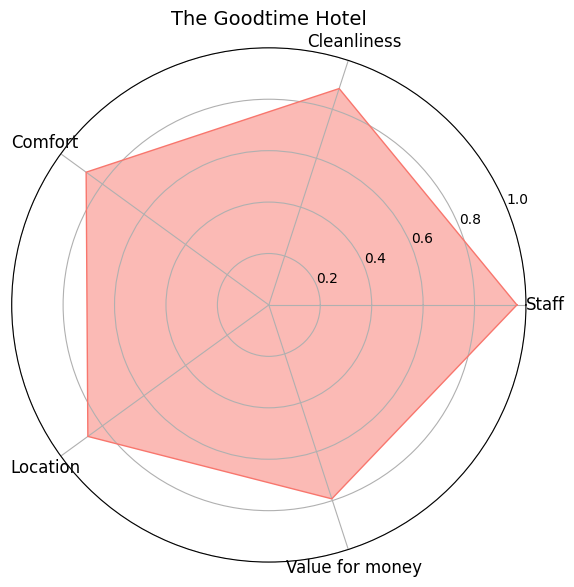

In [ ]:
hotel_scores, hotel_spider_result = absa_analyzer_obj.get_score_for_asset(hotel_name="The Goodtime Hotel" )

logger.info(f"hotel_scores: \n\n{hotel_scores}")

# API Development for ABSA results

The following App will return the ABSA scores for a given hotel and the corresponding Spider chart:

In [ ]:
# --- Defining the methods to use
# Semantic Search - Entire dataset + Reviews
def perform_semantic_search_hotel_reviews_app(query: str):
    """
    Function to run the Semantic Search on the dataset of Miami Hotels
    and their corresponding summaries.
    This function will return the top 10 elements.

    Parameters
    ------------
    query : str
        Query to feed to the search engine.

    Returns
    -----------
    top_n_results : list
        Variables corresponding to the list of results in JSON format.
    """

    top_n = search_engine_all_hotels_obj.search_reviews(
        query=query,
        top_n=10,
        max_number_reviews_per_hotel=4,
    )

    return top_n


# Semantic Search - Entire Dataset but using Hotel Summaries instead
def perform_semantic_search_hotel_summaries_app(query: str):
    """
    Function to run the Semantic Search on the dataset of Miami Hotels
    and their corresponding summaries.
    This function will return the top 10 elements.

    Parameters
    ------------
    query : str
        Query to feed to the search engine.

    Returns
    -----------
    top_n_results : list
        Variables corresponding to the list of results in JSON format.
    """

    top_n = semantic_search_hotel_summaries_obj.semantic_search(
        query=query,
        top_n=10,
    )

    return top_n

# ABSA - Extracts the ABSA scores and Spider chart for a given hotel.
def get_absa_scores_for_hotel_app(hotel_name: str):
    """
    Function to extract the ABSA scores of a given hotel.

    Parameters
    -------------
    hotel_name : str
        Name of the hotel to query.

    Returns
    -----------
    hotel_scores : dict
        Dictionary containing the scores for each of the different 'aspects'

    hotel_spider_chart : PIL.Image
        Image corresponding to the Spider chart of the hotel.
    """
    hotel_scores, hotel_spider_chart = absa_analyzer_obj.get_score_for_asset(hotel_name=hotel_name)

    return hotel_scores, hotel_spider_chart


# --- Defining the Gradio components

# Semantic Search - Entire dataset + Reviews
semantic_search_hotel_reviews = gr.Interface(
    fn=perform_semantic_search_hotel_reviews_app,
    inputs="text",
    outputs="json",
)

# Semantic Search - Entire Dataset but using Hotel Summaries instead
semantic_search_hotel_summaries = gr.Interface(
    fn=perform_semantic_search_hotel_summaries_app,
    inputs="text",
    outputs="json",
)

# ABSA scores
absa_interface = gr.Interface(
    fn=get_absa_scores_for_hotel_app,
    inputs=gr.inputs.Dropdown(choices=absa_analyzer_obj.hotel_names, label="Select a hotel",),
    outputs=[gr.Textbox(label="Hotel Aspects"), gr.outputs.Image(label="Spider Chart", type="pil")],
    title="ABSA Score Calculator",
    description="App that extracts the ABSA score of a given hotel."
)

# App combining both services
hotel_app = gr.TabbedInterface(
    [semantic_search_hotel_reviews, semantic_search_hotel_summaries, absa_interface],
    ["Semantic Search - Hotel Reviews", "Semantic Search - Hotel Summaries", "ABSA Scores"],
)


hotel_app.launch(
    share=True,
    debug=True,
)


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:219: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:222: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:919: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:919: UserWarning: api_name predict already exists, using predict_2
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c08a3a9ae4acbbb00c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c08a3a9ae4acbbb00c.gradio.live


# Summary of Findings

The findings of this project can be found here: [Notion Doc][notion_doc_url].


<!-- Links -->

[notion_doc_url]: https://petalite-toy-fea.notion.site/Week-4-Group-5-Miami-Hotels-Analysis-c30a1d99635c492d8b8b7e5635a0f9cc